In [2]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 50.4 MB 9.7 MB/s eta 0:00:011
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import cv2
import numpy as np

mean = [0.3852, 0.3761, 0.3258]
std = [0.0372, 0.0275, 0.0280]

def get_statistics():
    images_path = 'data/'
    width, height = [], []
    for sample in os.listdir(images_path):
        if os.path.isfile(images_path + sample + '/blurred/out.jpg'):
            pano = cv2.imread(images_path + sample + '/blurred/out.jpg')
            width.append(pano.shape[1])
            height.append(pano.shape[0])
    width = np.array(width)
    height = np.array(height)
    print('{} samples'.format(width.shape))
    print('width')
    print(' min : {}'.format(width.min()))
    print(' max : {}'.format(width.max()))
    print(' mean : {}'.format(width.mean()))
    print(' median : {}'.format(np.median(width)))
    print(' std : {}'.format(width.std()))
    print('height')
    print(' min : {}'.format(height.min()))
    print(' max : {}'.format(height.max()))
    print(' mean : {}'.format(height.mean()))
    print(' median : {}'.format(np.median(height)))
    print(' std : {}'.format(height.std()))
    print('percentage of panoramas with height less than 480 {}%'.format(100*round(np.count_nonzero(height < 480) / len(height), 2)))

def resize_and_fill_pano(x):
    h, w = x.shape[0], x.shape[1]
    w_resize = round(w/(h/96))
    x = cv2.resize(x, (w_resize, 96))
    out = np.ones((96, 6*128, 3))
    diff = 6*128 - x.shape[1]
    out[:, round(diff/2):x.shape[1] + round(diff/2), :] = x

    # normalization
    out = (out/255 - mean)/std
    return out

def create_dataset(path='/data/PanoramaGAN/panorama/'):
    data = os.listdir(path)
    X, Y = None, None
    for i, sample in enumerate(data):
        if i % 100 == 0:
            print(i)
        x = None
        images_list = os.listdir(path + sample)
        images_list.sort()
        for img_name in images_list:
            if img_name != 'out.jpg':
                img = cv2.imread(path + sample + '/' + img_name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 96))

                # normalization
                img = (img/255 - mean)/std
                img = img.astype('float32')

                if x is None:
                    x = img
                else:
                    x = np.concatenate((x, img), axis=-1)
            else:
                img = cv2.imread(path + sample + '/' + img_name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # reshape the pano to fit the 96*(6*128)
                img = resize_and_fill_pano(img).astype('float32')

                y = np.empty((96, 128, 3*6), dtype='float32')
                for i in range(6):
                    y[:, :, i*3:(i+1)*3] = img[:, 128*i:128*(i+1), :]
        x = np.expand_dims(x, axis=0)
        y = np.expand_dims(y, axis=0)
        if X is None:
            X = x
            Y = y
        else:
            X = np.concatenate((X, x), axis=0)
            Y = np.concatenate((Y, y), axis=0)
    np.savez('dataset', X, Y)

In [ ]:
import os

n = 3
path = 'data/'
in_path = '/data/panorama_{}/inputs/'.format(n)
out_path = '/data/panorama_{}/outputs/'.format(n)
dirs = os.listdir(path + 'unblurred/')
dirs.sort()
failed = []
for directory in dirs:
    images_list = os.listdir(path + 'unblurred/' + directory)
    images_list.sort()
    for i in range(len(images_list) - 2*(n-1)):
        sample_directory = directory + '_' + str(i+1).zfill(2)
        sample_not_in_inputs = sample_directory not in os.listdir(in_path)
        sample_not_in_outputs = sample_directory + '.jpg' not in os.listdir(out_path)
        if sample_not_in_inputs or sample_not_in_outputs:
            images = images_list[i:i+2*n:2]
            unblurred_images_path = path + 'unblurred/' + directory + '/'
            cmd = './image-stitching'
            for img in images:
                cmd += ' {}'.format(unblurred_images_path + img)
            os.system(cmd)
            if 'out.jpg' in os.listdir():
                os.system('mv out.jpg {}'.format(out_path + sample_directory + '.jpg'))
                try:
                    os.mkdir(in_path + sample_directory)
                except FileExistsError:
                    pass
                blurred_images_path = path + 'blurred/' + directory + '/'
                for img in images:
                    os.system('cp {} {}'.format(blurred_images_path + img, in_path + sample_directory + '/' + img))
            else:
                failed.append(sample_directory)
print(failed)

In [11]:
import os
import numpy as np
import cv2

n = []
for i in os.listdir('/data/panorama_15/outputs/'):
    img = cv2.imread('/data/panorama_15/outputs/' + i)
    nb_frames = (img.shape[1]/(img.shape[0]/96))/128
    n.append(nb_frames)
n = np.array(n)
print('min : {}'.format(n.min()))
print('max : {}'.format(n.max()))
print('median : {}'.format(np.median(n)))

min : 4.085616438356165
max : 5.6242138364779874
median : 5.178501945525292


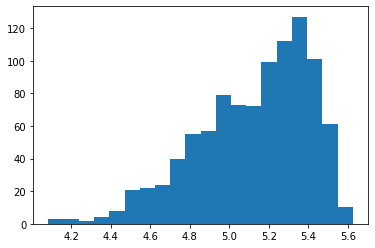

In [12]:
from matplotlib import pyplot as plt

plt.hist(n, bins=20)
plt.show()